### 영화리뷰 텍스트 감성분석하기 [프로젝트]
- 다양한 방법으로 Text Classification 구현
    - 3가지 이상의 모델
        - LSTM
        - RNN
        - CNN
        - Transformer
- genism을 활용하여 자체 학습된 혹은 사전 학습된 임베딩 레이어 분석
    - 유사단어 찾기 활용
    - 자체 학습 임제딩과 사전 학습 임베딩 비교
- 한국 Word2Vec을 사용한 가시적인 성능 향상
    - 네이버 리뷰 데이터 감성분석 정확도 85% 이상 달성
    

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas
import konlpy
import gensim

# 데이터 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
# data loader
# 데이터 중복 제거, NaN 결측치 제거, 한국어 토크나이저 토큰화, 불용어 제거
# 사전 word_to_index 구성
# x_train, y_train, x_test, y_test, word_to_index 리턴
from collections import Counter
from konlpy.tag import Mecab

# konlpy tokenizer
tokenizer = Mecab()
# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 데이터 불러오는 함수
def load_data(train_data, test_data, num_words=10000):
    # 중복 제거 및 Nan값 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 토콘화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # X_train을 list로 만들어서 word에 들어 있는 text를 하나로 합친다
    words = np.concatenate(X_train).tolist()
    
    # Counter로 가장 빈도가 높은 단어 추출 10000-4만큼 (용어, count(용어))
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    # 빈도 높은 단어로 word index 사전 만들기
    word_to_index = {word:index for index, word in enumerate(vocab)}
     
    # word 리스트를 인자로 받았을 때 index리스트로 변환해줌    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train. y_train, X_test , y_test
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

In [6]:
# 모든 문장은 Bos로 시작
# 단어 인덱스 리스트로 변환해주는 함수
def get_encoded_sentence(sentence,word_to_index):
    return [word_to_indexp['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentences.split() ]


# 여러 문장 리스트를 한번에 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence,word_to_index) for sentence in sentences]
# 변수에 담아서 출력하면 [[list 형태의 문장 index가  출력됨]]

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded in encoded_sentences]


# 앞문장 BoS는 제거해주고, index가 index_to word에 없으면 Unkown으로 처리
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외


In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 데이터 load_data함수 사용해서 train, test, 데이터 만들기
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

### LSTM

In [17]:
# 실제 인코딩 인덱스는 제공된 word_to_index 기준으로 3씩 뒤로 밀려 있다
word_to_index ={k:(v+3) for k,v in word_to_index.items()}


# 처음 몇개의 인덱스는 사전 정의
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3
index_to_word = {index:word for word, index in word_to_index.items()}

In [18]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
# paddding은 post로 진행
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [99]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 250  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - Bi-LSTM 모델
# Dropout로 과적합 방지
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128,dropout=0.3, recurrent_dropout=0.2, return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.LSTM(128,dropout=0.5))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 250)         2500000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 128)         194048    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,825,761
Trainable params: 2,825,761
Non-trainable params: 0
_________________________________________________________________


In [22]:
# validation set 10000건 분리
x_val = x_train[:26182]   
y_val = y_train[:26182]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[26182:]  
partial_y_train = y_train[26182:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(120000, 41)
(120000,)


In [101]:
# 최적화 함수 Adam, RMSprops
opt = tf.keras.optimizers.Adam()

# 손실함수 binary_crossentropy 사용
model.compile(optimizer=opt, # 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [102]:
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# batch는 256 , 512 , 1024로 무두 진행
# 512가 가장 성능이 좋았음
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
235/235 [==============================] - 50s 200ms/step - loss: 0.4427 - accuracy: 0.7729 - val_loss: 0.3491 - val_accuracy: 0.8466
Epoch 2/5
235/235 [==============================] - 46s 196ms/step - loss: 0.3324 - accuracy: 0.8574 - val_loss: 0.3438 - val_accuracy: 0.8508
Epoch 3/5
235/235 [==============================] - 46s 197ms/step - loss: 0.2968 - accuracy: 0.8725 - val_loss: 0.3268 - val_accuracy: 0.8586
Epoch 4/5
235/235 [==============================] - 46s 196ms/step - loss: 0.2665 - accuracy: 0.8876 - val_loss: 0.3328 - val_accuracy: 0.8602
Epoch 5/5
235/235 [==============================] - 46s 197ms/step - loss: 0.2427 - accuracy: 0.9000 - val_loss: 0.3517 - val_accuracy: 0.8602


In [103]:
# 결과 출력
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 20s - loss: 0.3626 - accuracy: 0.8538
[0.36262834072113037, 0.8538356423377991]


In [104]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


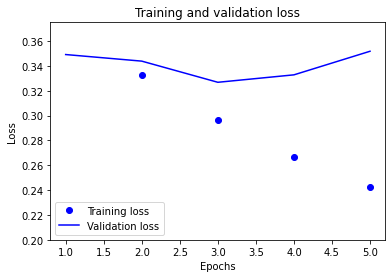

In [109]:
# 손실함수 그래프 확인
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.20,0.375)
plt.legend()

plt.show()


In [106]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 250)


- embedding layer 16부터 최대 300까지 진행해 보았는데 높은 경우가 더 성능이 좋았음
- 하지만 너무 높다고 높아지지는 않았음

### LSTM & Word2Vec

In [111]:
# Word2VecKeyedVectors를 사용해 기본 LSTM으로 한 모델과 비교
from gensim.models.keyedvectors  import Word2VecKeyedVectors
import os

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv["끝"]
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [112]:
word2vec.wv.similar_by_word("슬픔")

[('기쁨', 0.8425582647323608),
 ('비탄', 0.8262216448783875),
 ('아픔', 0.8158854842185974),
 ('연민', 0.8140999674797058),
 ('그리움', 0.8060039281845093),
 ('외로움', 0.8035392165184021),
 ('질투심', 0.7967507243156433),
 ('절망', 0.7751548886299133),
 ('죄책감', 0.7746415734291077),
 ('번민', 0.7715185880661011)]

In [189]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 250  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4, vocab_size):
    word = index_to_word[i]
    try:
        embedding_matrix[i] = word2vec[word
    except:
        pass

In [196]:
# 이전과 동일하게 진행
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 250  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_shape=(None,),
                                   trainable=True))
model.add(tf.keras.layers.LSTM(128,dropout=0.3, recurrent_dropout=0.2, return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.LSTM(128,dropout=0.5))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.



model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 250)         2500000   
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 128)         194048    
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 2,825,761
Trainable params: 2,825,761
Non-trainable params: 0
_________________________________________________________________


In [197]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [198]:
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
235/235 [==============================] - 51s 200ms/step - loss: 0.6569 - accuracy: 0.5644 - val_loss: 0.4333 - val_accuracy: 0.8052
Epoch 2/8
235/235 [==============================] - 47s 198ms/step - loss: 0.4127 - accuracy: 0.8157 - val_loss: 0.3527 - val_accuracy: 0.8463
Epoch 3/8
235/235 [==============================] - 46s 197ms/step - loss: 0.3597 - accuracy: 0.8448 - val_loss: 0.3430 - val_accuracy: 0.8519
Epoch 4/8
235/235 [==============================] - 46s 197ms/step - loss: 0.3351 - accuracy: 0.8584 - val_loss: 0.3301 - val_accuracy: 0.8580
Epoch 5/8
235/235 [==============================] - 46s 198ms/step - loss: 0.3162 - accuracy: 0.8668 - val_loss: 0.3231 - val_accuracy: 0.8606
Epoch 6/8
235/235 [==============================] - 47s 200ms/step - loss: 0.3055 - accuracy: 0.8721 - val_loss: 0.3222 - val_accuracy: 0.8602
Epoch 7/8
235/235 [==============================] - 46s 198ms/step - loss: 0.2936 - accuracy: 0.8775 - val_loss: 0.3213 - val_accuracy:

In [199]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 20s - loss: 0.3396 - accuracy: 0.8567
[0.33957505226135254, 0.8566633462905884]


In [200]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


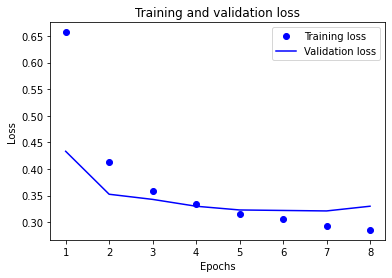

In [201]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


- 성능 0.0030정도 올라갔다. epoch 수를 적게 해서 엄청난 발전이 있는 것 같지는 않다
- 하지만 그래프 확인 결과 이전 손실함수 그래프보다 훨씬 안정적으로  validation loss가 감소한다.
- 과적합이 생각보다 빠르게 일어나서 모델에 조금 더 깊이를 만들거나, regularization을 해줘야 할 것 같다.
- 데이터를 자세히 살펴보고 전처리를 해보는 것도 좋은 시도일 수 있을 것 같다

### RNN

In [131]:
# 위와 동일한 데이터 셋을 가지고  RNN으로 진행
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim,       
                                    input_shape=(None,),
                                   trainable=True))
model.add(tf.keras.layers.SimpleRNN(32,dropout=0.3, recurrent_dropout=0.2, return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능) # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, None, 32)          10656     
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           33        
Total params: 3,010,689
Trainable params: 3,010,689
Non-trainable params: 0
_________________________________________________________________


In [132]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [133]:
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
235/235 [==============================] - 18s 71ms/step - loss: 0.5239 - accuracy: 0.7506 - val_loss: 0.4450 - val_accuracy: 0.8052
Epoch 2/5
235/235 [==============================] - 16s 70ms/step - loss: 0.4383 - accuracy: 0.8154 - val_loss: 0.4577 - val_accuracy: 0.8083
Epoch 3/5
235/235 [==============================] - 17s 70ms/step - loss: 0.4177 - accuracy: 0.8253 - val_loss: 0.4480 - val_accuracy: 0.8099
Epoch 4/5
235/235 [==============================] - 16s 69ms/step - loss: 0.4063 - accuracy: 0.8307 - val_loss: 0.4354 - val_accuracy: 0.8122
Epoch 5/5
235/235 [==============================] - 16s 69ms/step - loss: 0.3995 - accuracy: 0.8331 - val_loss: 0.4159 - val_accuracy: 0.8134


In [134]:
# 결과
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.4216 - accuracy: 0.8117
[0.4215710759162903, 0.8116781115531921]


In [135]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


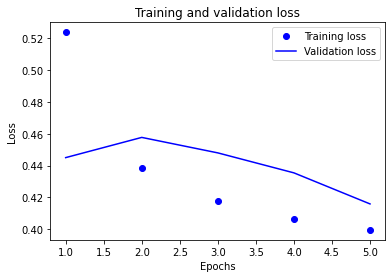

In [136]:
# 손실 그래프 살펴보기
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

### RNN & Word2Vec

In [202]:
# word2vec 불러오기
from gensim.models.keyedvectors  import Word2VecKeyedVectors
import os

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv["끝"]
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [221]:
# 임베딩 matrix 만들기
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4, vocab_size):
    word = index_to_word[i]
    try:
        embedding_matrix[i] = word2vec[word
    except:
        pass

In [241]:
# Constant는 지정한 파라미터를 특정한 상수값으로 생성
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
model = tf.keras.Sequential()
# trainable은 선택적 단계
# 기본 모델의 일부 또는 전부를 동결 해제(?)하고 학습률이 매우 낮은 새로운 데이터에 대해 재훈련 과정 
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_shape=(None,),
                                   trainable=True))
model.add(tf.keras.layers.SimpleRNN(32,dropout=0.3, recurrent_dropout=0.2, return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능) # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.



model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, None, 32)          10656     
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           33        
Total params: 3,010,689
Trainable params: 3,010,689
Non-trainable params: 0
_________________________________________________________________


In [242]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [243]:
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
235/235 [==============================] - 18s 71ms/step - loss: 0.6974 - accuracy: 0.5210 - val_loss: 0.6747 - val_accuracy: 0.5501
Epoch 2/5
235/235 [==============================] - 16s 69ms/step - loss: 0.6673 - accuracy: 0.5785 - val_loss: 0.6899 - val_accuracy: 0.5038
Epoch 3/5
235/235 [==============================] - 16s 69ms/step - loss: 0.6858 - accuracy: 0.5304 - val_loss: 0.6791 - val_accuracy: 0.5434
Epoch 4/5
235/235 [==============================] - 16s 69ms/step - loss: 0.6731 - accuracy: 0.5494 - val_loss: 0.6496 - val_accuracy: 0.5810
Epoch 5/5
235/235 [==============================] - 16s 68ms/step - loss: 0.6232 - accuracy: 0.6304 - val_loss: 0.5122 - val_accuracy: 0.7833


In [244]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 8s - loss: 0.5152 - accuracy: 0.7801
[0.5152367949485779, 0.7801331281661987]


In [245]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


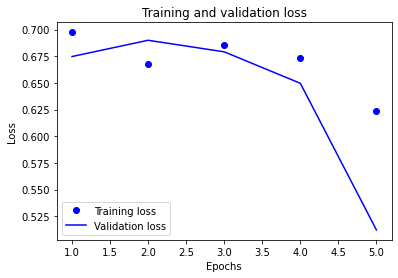

In [246]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [247]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [ ]:
history_dict = history.history
print(history_dict.keys())

- 특이하게도 단순 RNN을 가지고 훈렸했을 때와 Word2Vec로 훈련했을 때 비교를 해보았는데 하지 않았을 때가 더 높게 나타났다.. 훈련 과정을 너무 적게 했거나, 너무 단순한 모델이라서 그런 것이 아닐까 싶다.

### CNN

In [39]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 250  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                   ))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 250)           2500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            28016     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
235/235 [==============================] - 8s 13ms/step - loss: 0.4553 - accuracy: 0.7627 - val_loss: 0.3415 - val_accuracy: 0.8522
Epoch 2/5
235/235 [==============================] - 2s 7ms/step - loss: 0.3035 - accuracy: 0.8723 - val_loss: 0.3323 - val_accuracy: 0.8539
Epoch 3/5
235/235 [==============================] - 2s 7ms/step - loss: 0.2408 - accuracy: 0.9041 - val_loss: 0.3447 - val_accuracy: 0.8529
Epoch 4/5
235/235 [==============================] - 2s 7ms/step - loss: 0.1683 - accuracy: 0.9385 - val_loss: 0.3871 - val_accuracy: 0.8496
Epoch 5/5
235/235 [==============================] - 2s 7ms/step - loss: 0.1076 - accuracy: 0.9636 - val_loss: 0.4760 - val_accuracy: 0.8420


In [43]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4827 - accuracy: 0.8380
[0.4826851487159729, 0.8379681706428528]


In [45]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


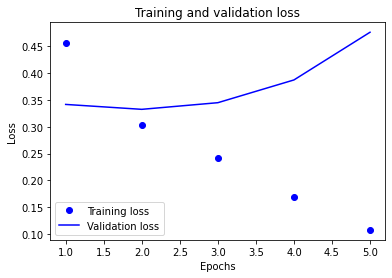

In [46]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### CNN Word2Vec

In [1]:
from gensim.models.keyedvectors  import Word2VecKeyedVectors
import os

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv["끝"]
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [12]:
# 임베딩 matrix 만들기
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4, vocab_size):
    word = index_to_word[i]
    try:
        embedding_matrix[i] = word2vec[word]
    except:
        pass


In [20]:
# Constant는 지정한 파라미터를 특정한 상수값으로 생성
from tensorflow.keras.initializers import Constant
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 300)           3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
235/235 [==============================] - 6s 10ms/step - loss: 0.6455 - accuracy: 0.6080 - val_loss: 0.4584 - val_accuracy: 0.7906
Epoch 2/5
235/235 [==============================] - 2s 8ms/step - loss: 0.3994 - accuracy: 0.8214 - val_loss: 0.3763 - val_accuracy: 0.8336
Epoch 3/5
235/235 [==============================] - 2s 8ms/step - loss: 0.3343 - accuracy: 0.8573 - val_loss: 0.3699 - val_accuracy: 0.8376
Epoch 4/5
235/235 [==============================] - 2s 8ms/step - loss: 0.3033 - accuracy: 0.8731 - val_loss: 0.3510 - val_accuracy: 0.8484
Epoch 5/5
235/235 [==============================] - 2s 8ms/step - loss: 0.2779 - accuracy: 0.8866 - val_loss: 0.4093 - val_accuracy: 0.8220


In [24]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4212 - accuracy: 0.8199
[0.42120474576950073, 0.819903552532196]


In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


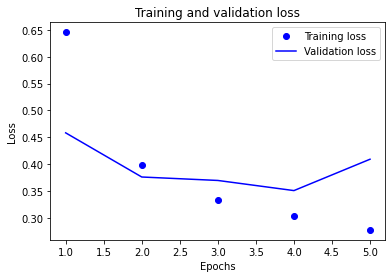

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Transformer

In [1]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-excws4e0
  Running command git clone --filter=blob:none -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-excws4e0
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 129 kB 6.0 MB/s            
     |████████████████████████████████| 344 kB 36.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 54.7 MB 21 kB/s              
     |████████████████████████████████| 4.5 MB 53.6 MB/s            
     |████████████████████████████████| 2.5 MB 37.0 MB/s            
     |████████████████████████████████| 73 kB 3.6 MB/s             
     |████████████████████████████████| 6.7 MB 62.4 MB/s            
     |████████████████████████████████| 127 kB 94.5 MB/s            
  Created wheel for kobert: fil

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

In [4]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [5]:

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [6]:
device = torch.device("cpu")


In [7]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

using cached model. /aiffel/aiffel/Aiffel_online_Quest/Quest04/.cache/kobert_v1.zip
using cached model. /aiffel/aiffel/Aiffel_online_Quest/Quest04/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [9]:
!wget -O .cache/ratings_train.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
!wget -O .cache/ratings_test.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_test.txt

--2023-11-23 23:55:43--  http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
Resolving skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)... 52.219.148.51, 52.219.146.87, 52.219.146.91, ...
Connecting to skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)|52.219.148.51|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘.cache/ratings_train.txt’

.cache/ratings_trai 100%[===================>]  13.95M  10.6MB/s    in 1.3s    

2023-11-23 23:55:44 (10.6 MB/s) - ‘.cache/ratings_train.txt’ saved [14628807/14628807]

--2023-11-23 23:55:45--  http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_test.txt
Resolving skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)... 52.219.60.118, 52.219.60.94, 52.219.148.87, ...
Connecting to skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)|52.219.60.118|:80... connec

In [10]:
dataset_train = nlp.data.TSVDataset(".cache/ratings_train.txt", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset(".cache/ratings_test.txt", field_indices=[1,2], num_discard_samples=1)
# 결과가 [[문장, label]]

In [ ]:
x_train = X_train.copy()
y_train = y_train.copy()
df_train= pd.DataFrame({
    "document":x_train,
    "label": y_train
})
df_train
dataset_train = df_train[["document","label"]].values.tolist()
x_test = X_test.copy()
y_test = y_test.copy()
df_test= pd.DataFrame({
    "document":x_test,
    "label": y_test
})
df_test
dataset_train = df_test[["document","label"]].values.tolist()

In [15]:
np.array(dataset_test[:]).shape

(50000, 2)

In [16]:
# 토크나이징 및 임베딩 작업
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /aiffel/aiffel/Aiffel_online_Quest/Quest04/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [17]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [18]:
## Setting parameters
max_len = 64
batch_size = 256
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [19]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [20]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [22]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [23]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [24]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [25]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [26]:
# 트랜스포머 모델의 스케줄러는 학습률을 조절하는 역할 - 학습이 진행되면 학습률을 줄임
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


In [27]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc


In [28]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/2344 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.7366246581077576 train acc 0.46875
epoch 1 batch id 201 loss 0.43987104296684265 train acc 0.5649875621890548
epoch 1 batch id 401 loss 0.46243298053741455 train acc 0.6777197630922693
epoch 1 batch id 601 loss 0.4453789293766022 train acc 0.7303452579034941


KeyboardInterrupt: 

- Transformer 모델은 koBERT 오픈소스 모델을 사용
- KoBERT
    - 학습셋
        - 한국어 위키	5M	54M
- 다른 모델에 비해 학습시간이 매우 오래걸렸다.
- 학습을 batch 단위로 나눠서 진행는 것 같다. 너무 길어서 어느 정도 정확도를 달성한 뒤에는 멈췄다.

## 회고

### 서론
다양한 모델을 이용해 네이버 리뷰 감성분석을 해본다.

### 개발 과정
- 공통 과정
    - 데이터 불러오기
    - 데이터 전처리 및 load
    - 패딩 처리(Transformer 모델 제외)
    - 임베딩 처리
- RNN 모델 구성
    - 단순 simpleRNN
- LSTM 모델 구성
    - Bi-LSTM으로 구성
- CNN 모델 구성
- Ko-BERT 모델 활용
    - Transformer 모델 같은 경우에는 어텐션 메커니즘을 사용하면 입력 시퀀스의 각 위치에 대해 가중치를 부여하기 때문에 패딩을 사용해서 시퀀스 길이를 맞춰줄 필요가 상대적으로 적다.

### 배운 점 및 회고
- 과적합이 생각보다 빠르게 와서 당황했지만, Dropout과 optimzier를 바꿔가면서 진행해보았다. 그런데 Dropout이 효과가 조금 있었다. 
- LSTM 모델은 하나를 할 때보다, 두 개를 연속으로한 Bi-LSTM이 더 효과가 좋았다. 아마도 좀 더 표현력이 더 많아져서 그런 것 이 아닐까 싶다. Dense layer와 함께 해보았지만 LSTM 모델로 하고 output layer만 Dense로 구성하는 것이 가장 효과가 좋았다
- 하지만 LSTM이 RNN의 한계를 개선하고자, 장 단기 기억으로 가져가는 것은 맞지만 결국 word vector dic가 있어야하기 때문에 여전히 문장이 길어졌을 때는 한계가 있을 것으로 보인다
- RNN은 다른 것들에 비해 성능이 떨어졌지만 그래도 초창기 모델을 직접 사용해 보았다는 것에 의미를 두려고 한다
- Transformer 모델은 기존의 LSTM과 RNN의 모델의 한계를 다른 방향으로 해결한 모델로서 사용해보고 싶었다 Transformer 인코더에 대표 모델인 BERT를 사용해 보았는데 기존의 Bert가 한국의 한계가 있어서 만든 Ko-BERT를 직접 사용해보았다. 학습속도가 너무 느렸지만, 조금 시간을 가지고 했을 때 가장 성능이 좋을 것이라고 예상해 보해본다.